In [1]:
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.gaussian_process import GaussianProcess
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

2022-05-19 19:36:27.017106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 19:36:27.017124: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from data_preparation import *


In [3]:
sampling_distance_x = 2
sampling_distance_y = 24
length = 1000 
whole_map = pd.read_csv('WholeMap_Rounds_40_to_17.csv')
map = stack_map(whole_map) # create a stacked map dataframe with columns x, y, z
map = cut_map_len(map,length) # cut the map to the length of the map
data_i, data_o = resample(map, sampling_distance_x, sampling_distance_y) # resample the map


In [4]:
x = map['x'].unique()#/data_i.x.max()
y = map['y'].unique()#/data_i.y.max()


In [5]:
map['y'].unique()

array([   0,    1,    2, ..., 1198, 1199, 1200])

In [6]:
s1, s2 = np.meshgrid(x,y)
s = np.vstack((s1.flatten(),s2.flatten())).T


In [7]:
N = s1.flatten().shape[0]
N

156130

In [8]:
"""
y_i = np.zeros(len(s_i[:,0]))
for i in range(len(s_i[:,0])):
    y_i[i]=(data_i[data_i.x==s_i[i,0]][data_i.y==s_i[i,1]]['z'])
y_o = np.zeros(len(s_o[:,0]))
for i in range(len(s_o[:,0])):
    y_o[i]=(data_o[data_o.x==s_o[i,0]][data_o.y==s_o[i,1]]['z'])
"""

y = map['z']

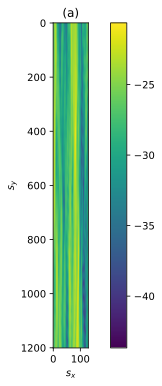

In [9]:
##Visualization
y_mat = map.pivot_table(index='y', columns='x', values='z').to_numpy()#.iloc[:100].to_numpy()
fig, ax = plt.subplots()
im = ax.imshow(y_mat ,
               vmax=y_mat.max(), vmin=y_mat.min())
plt.xlabel('$s_x$')
plt.ylabel('$s_y$')
plt.title('(a)')
plt.colorbar(im)
#plt.show()
plt.savefig("nonstat_fun_2d.pdf")

In [10]:
num_basis =  [10**2,19**2,37**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi= np.zeros((N, sum(num_basis)))

for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
                
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [11]:
pd.DataFrame(phi)

,0,1,2,3,4,5,6,7,8,9,...,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829
0,1.0,0.17556,0.000029,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000029,0.17556,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156125,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156126,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156127,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156128,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
pd.DataFrame(phi).to_csv('phi_wendland.csv')

In [39]:
phi = pd.read_csv('phi_wendland.csv')

In [41]:
phi.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828',
       '1829'],
      dtype='object', length=1831)

In [42]:
phi = phi.drop(columns=['Unnamed: 0'])

In [43]:
phi=phi.to_numpy()

In [45]:
phi=pd.DataFrame(phi)
phi

,0,1,2,3,4,5,6,7,8,9,...,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829
0,1.0,0.17556,0.000029,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000029,0.17556,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156125,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156126,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156127,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156128,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Remove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))


In [15]:
phi_reduce = np.delete(phi,idx_zero,1)
print(f'shape phi before reduction: {phi.shape}')
print(f'shpae phi after reduction  {phi_reduce.shape}')

shape phi before reduction: (156130, 1831)
shpae phi after reduction  (156130, 97)


In [17]:
pd.DataFrame(phi_reduce)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0,1.0,0.17556,0.000029,0.000000,0.00000,0.0,0.17556,0.024643,1.041887e-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.00000,0.000000,0.000029,0.17556,1.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156125,156125.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156126,156126.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156127,156127.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156128,156128.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
phi = pd.DataFrame(phi_reduce)

In [19]:
tf.keras.metrics.MeanAbsolutePercentageError(
    name="mean_absolute_percentage_error", dtype=None
)

def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    #sgd = optimizers.gradient_descent_v2.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return model, history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results_test = model.evaluate(X_test, y_test, verbose=0)
    results_train = model.evaluate(X_train, y_train, verbose=0)
    return results_test, results_train
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch



2022-05-19 19:52:55.649492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 19:52:55.649726: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 19:52:55.650106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (schmijul-thinkpad): /proc/driver/nvidia/version does not exist
2022-05-19 19:52:55.652783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
# DeepKriging model for continuous data with 4 hidden layers
model_4 = Sequential()
model_4.add(Dense(100, input_dim = phi_reduce.shape[1],  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_4.add(Dense(1, activation='linear'))

In [65]:
# Baseline DNN only with coordinates
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=2,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='linear'))

In [66]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [67]:
def mse(y_pred,y_true):
    mse = np.mean((y_pred-y_true)**2)
    return mse

def mae(y_pred,y_true):
    mae = np.mean(np.absolute(y_pred-y_true))
    return mae

def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return mape

In [70]:
phi_reduce = pd.DataFrame(phi_reduce)

In [71]:
x_train = phi_reduce.iloc[data_i.index].to_numpy()
y_train = data_i.z.to_numpy()
x_val = phi_reduce.iloc[data_o.index].to_numpy()
y_val = data_o.z.to_numpy()

In [72]:
p=phi.shape[1]

In [73]:
model = Sequential()
model.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))


In [74]:
model, history = deep_model( model_4, x_train, y_train, x_val, y_val, 'continuous')

In [113]:
pd.DataFrame(history.history)[['loss','val_loss']]

,loss,val_loss
0,3.764072e+06,49178.523438
1,2.888550e+03,215.558517
2,4.927538e+02,232.445328
3,1.267374e+03,889.312744
4,2.675448e+02,220.584732
...,...,...
195,1.412804e+02,80.297028
196,1.007408e+02,90.290184
197,9.246810e+01,78.397957
198,1.996330e+02,79.265831


(0.0, 2000.0)

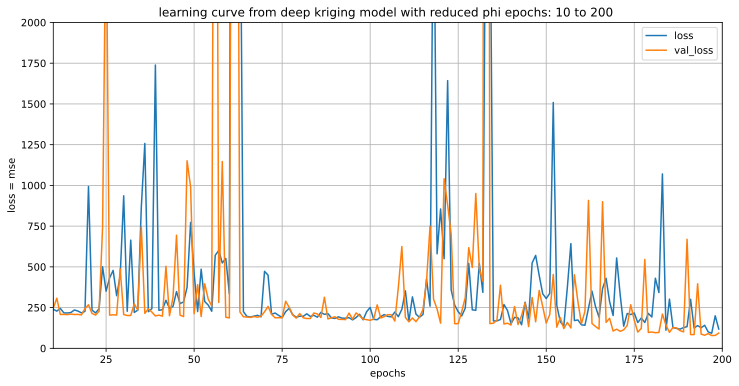

In [128]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(12,6),grid=True)
plt.title('learning curve from deep kriging model with reduced phi epochs: 10 to 200 ')
plt.xlabel('epochs')
plt.ylabel('loss = mse')
plt.xlim(10,200)
plt.ylim(0,2000)

In [76]:
prediction = model.predict(x_val)

100/100 [==============================] - 0s 980us/step


In [77]:
prediction = pd.DataFrame(prediction)

In [78]:
prediction.index = data_o.index

In [79]:
pred_stacked = pd.merge(data_o[['x','y']], prediction,how='inner', left_index=True, right_index=True)

In [80]:
pred_stacked.columns = ['x','y','z']

Text(0, 0.5, 'values')

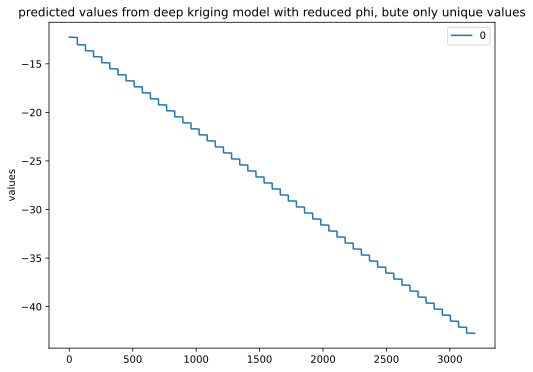

In [134]:
pd.DataFrame(pred_stacked.z.unique()).plot()
plt.title('predicted values from deep kriging model with reduced phi, bute only unique values')
plt.ylabel('values')

In [129]:
len(pred_stacked.z.unique())

3197

In [135]:
len(pred_stacked.z)

3200

In [136]:
len(data_o.z)

3200

In [82]:
import seaborn as sns

Text(0.5, 1.0, 'validation data')

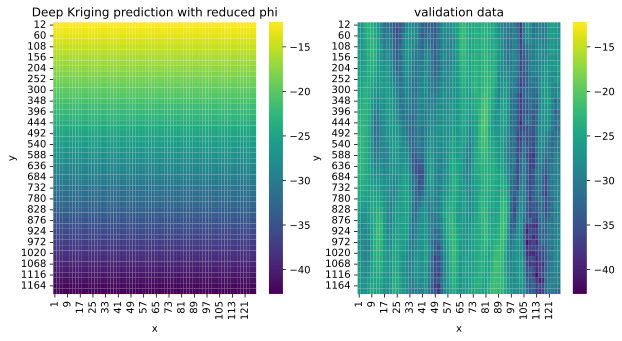

In [98]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1,2), (0, 1))

sns.heatmap(ax=ax1,data=pred_stacked.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
sns.heatmap(ax=ax2,data=data_o.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
ax1.set_title('Deep Kriging prediction with reduced phi')
ax2.set_title('validation data')

In [90]:
vmin = np.min([pred_stacked.z.min(),data_o.z.min()])
vmax = np.max([pred_stacked.z.max(),data_o.z.max()])

Text(0.5, 1.0, 'Deep Kriging prediction with reduced phi')

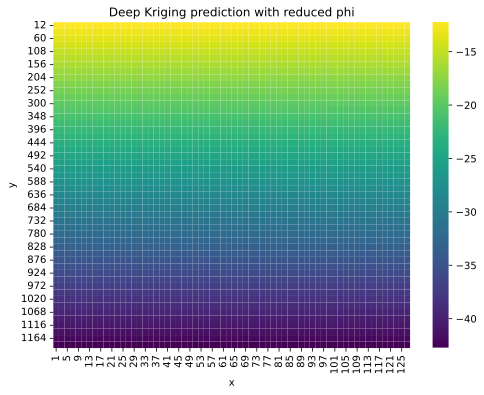

In [91]:
sns.heatmap(pred_stacked.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')


Text(0.5, 1.0, 'validation data')

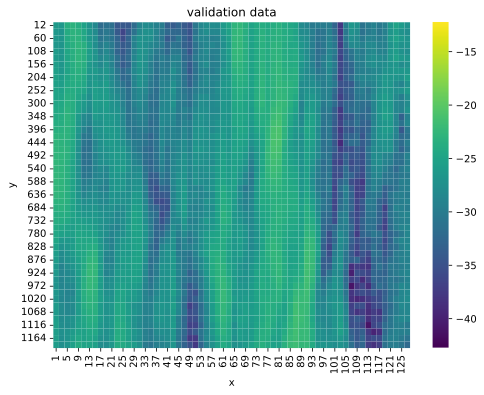

In [92]:
sns.heatmap(data_o.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
plt.title('validation data')

In [ ]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
fold_no = 1
inputs = phi
inputs_base = s
targets = y
rmse_per_fold = []
rmse_per_fold_base = []
rmse_per_fold_gp = []
mape_per_fold = []
mape_per_fold_base = []
mape_per_fold_gp = []
rmse_per_fold_train = []
rmse_per_fold_base_train = []
rmse_per_fold_gp_train = []
mape_per_fold_train = []
mape_per_fold_base_train = []
mape_per_fold_gp_train = []
for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = deep_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:], targets[test_idx],'continuous')
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx]
                              , inputs_base[test_idx], targets[test_idx],'continuous')
    model_optim = optimal_epoch(history)
    model_optim_base = optimal_epoch(history_base)
    result = test_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:]
                        , targets[test_idx], model_optim)
    result_base = test_model(model_base, inputs_base[train_idx,:], targets[train_idx], inputs_base[test_idx,:]
                             , targets[test_idx], model_optim_base)
    scores = result
    scores_base = result_base
    print(f'The performance of DeepKriging: RMSE = {scores[0][1]}, MAPE = {scores[0][2]}')
    print(f'The performance of classical DNN: RMSE = {scores_base[0][1]}, MAPE = {scores_base[0][2]}')
    #ker = GPy.kern.Exponential(2,1,1)
    #ker = GPy.kern.Matern32(2,1,1)
    ker = GPy.kern.RBF(2,1,1)
    # create simple GP model
    m = GPy.models.GPRegression(s[train_idx],targets[train_idx,None],ker)
    # optimize and plot
    m.optimize(messages=True)
    z_gp_test,gp_var=m.predict(s[test_idx])
    z_gp_train,gp_train=m.predict(s[train_idx])
    scores_gp = [rmse(z_gp_test[:,0],targets[test_idx]),mape(z_gp_test[:,0],targets[test_idx])]
    scores_gp_train = [rmse(z_gp_train[:,0],targets[train_idx]),mape(z_gp_train[:,0],targets[train_idx])]
    print(f'The performance of Kriging: RMSE = {scores_gp[0]}, MAPE = {scores_gp[1]}')
    fold_no = fold_no + 1
    
    # Results for testing dataset
    rmse_per_fold.append(scores[0][1])
    rmse_per_fold_base.append(scores_base[0][1])
    rmse_per_fold_gp.append(scores_gp[0])
    mape_per_fold.append(scores[0][2])
    mape_per_fold_base.append(scores_base[0][2])
    mape_per_fold_gp.append(scores_gp[1])  
    
    # Results for training dataset
    rmse_per_fold_train.append(scores[1][1])
    rmse_per_fold_base_train.append(scores_base[1][1])
    rmse_per_fold_gp_train.append(scores_gp_train[0])
    mape_per_fold_train.append(scores[1][2])
    mape_per_fold_base_train.append(scores_base[1][2])
    mape_per_fold_gp_train.append(scores_gp_train[1]) 
    
    

ValueError: Found input variables with inconsistent numbers of samples: [39204, 198]

In [ ]:
import matplotlib as mpl
mpl.style.use("seaborn")
data= [rmse_per_fold,rmse_per_fold_base,rmse_per_fold_gp]
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_subplot(111) 
  
# Creating axes instance 
bp = ax.boxplot(data, patch_artist = True, 
                notch ='True', vert = 0) 
  
colors = ['#0000FF', '#00FF00',  
          '#FFFF00'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
  
# changing color and linewidth of 
# whiskers 
for whisker in bp['whiskers']: 
    whisker.set(color ='black', 
                linewidth = 1.5, 
                linestyle =":") 
  
# changing color and linewidth of 
# caps 
for cap in bp['caps']: 
    cap.set(color ='#8B008B', 
            linewidth = 2) 
  
# changing color and linewidth of 
# medians 
for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 
  
# changing style of fliers 
for flier in bp['fliers']: 
    flier.set(marker ='D', 
              color ='#e7298a', 
              alpha = 0.5) 
      
# x-axis labels 
ax.set_yticklabels(['DeepKriging', 'Baseline DNN',  
                    'Kriging']) 
  
# Adding title  
plt.title("(b)") 
plt.xlabel('Root Mean Squared Error based on 10-fold cross validation')
#plt.xlim((0,0.02)) 
# Removing top axes and right axes 
# ticks 
ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left() 
      
# show plot 
#plt.show(bp) 
plt.savefig("boxplot_new.pdf")

In [ ]:
# Print results for the testing set
print(np.mean(rmse_per_fold))
print(np.std(rmse_per_fold))
print(np.mean(rmse_per_fold_base))
print(np.std(rmse_per_fold_base))
print(np.mean(rmse_per_fold_gp))
print(np.std(rmse_per_fold_gp))
print(np.mean(mape_per_fold))
print(np.std(mape_per_fold))
print(np.mean(mape_per_fold_base))
print(np.std(mape_per_fold_base))
print(np.mean(mape_per_fold_gp))
print(np.std(mape_per_fold_gp))

0.010539589682593942
0.002460980954048004
0.08805471882224084
0.012943016491387628
0.004432331649270907
0.008313523407641348
14.718188953399657
6.4095478315893715
97.0429801940918
9.51201371752292
0.0015075278696577445
0.0014551510647627934


In [ ]:
# Print results for the training set

print(np.mean(rmse_per_fold_train))
print(np.std(rmse_per_fold_train))
print(np.mean(rmse_per_fold_base_train))
print(np.std(rmse_per_fold_base_train))
print(np.mean(rmse_per_fold_gp_train))
print(np.std(rmse_per_fold_gp_train))
print(np.mean(mape_per_fold_train))
print(np.std(mape_per_fold_train))
print(np.mean(mape_per_fold_base_train))
print(np.std(mape_per_fold_base_train))
print(np.mean(mape_per_fold_gp_train))
print(np.std(mape_per_fold_gp_train))

0.010675040073692799
0.002311269814538169
0.08782033324241638
0.0073355055779713
3.2349213394679624e-05
4.065972743346282e-06
14.263153171539306
3.6769348184127657
94.93298263549805
5.737350444260662
5.428707775092566e-05
1.3134156288456762e-05
